In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_pickle("./data/train.pkl")

In [3]:
def make_is_bad_zero(group, min_interval=48, summer_start=3000, summer_end=7500):
    """Helper routine for 'find_bad_zeros'.

    This operates upon a single dataframe produced by 'groupby'. We expect an
    additional column 'meter_id' which is a duplicate of 'meter' because groupby
    eliminates the original one."""
    meter = group.meter.iloc[0]
    is_zero = group.meter_reading == 0
    if meter == 0:
        # Electrical meters should never be zero. Keep all zero-readings in this table so that
        # they will all be dropped in the train set.
        return is_zero

    transitions = (is_zero != is_zero.shift(1))
    all_sequence_ids = transitions.cumsum()
    ids = all_sequence_ids[is_zero].rename("ids")
    if meter in [2, 3]:
        # It's normal for steam and hotwater to be turned off during the summer
        keep = set(ids[(group.timestamp < summer_start) |
                       (group.timestamp > summer_end)].unique())
        is_bad = ids.isin(keep) & (ids.map(ids.value_counts()) >= min_interval)
    elif meter == 1:
        time_ids = ids.to_frame().join(group.timestamp).set_index("timestamp").ids
        is_bad = ids.map(ids.value_counts()) >= min_interval

        # Cold water may be turned off during the winter
        jan_id = time_ids.get(0, False)
        dec_id = time_ids.get(8283, False)
        if (jan_id and dec_id and jan_id == time_ids.get(500, False) and
                dec_id == time_ids.get(8783, False)):
            is_bad = is_bad & (~(ids.isin(set([jan_id, dec_id]))))
    else:
        raise Exception(f"Unexpected meter type: {meter}")

    result = is_zero.copy()
    result.update(is_bad)
    return result

In [9]:
def meter_0_bad_zero(df):
    return df.meter_reading == 0

In [7]:
len(meter_0_bad_zero(df[df.meter == 0]))

530169

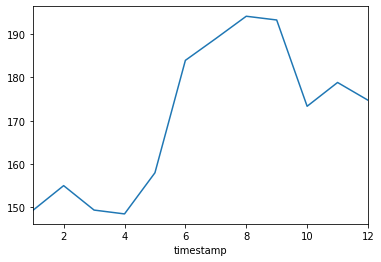

In [15]:
df[df.meter == 0].groupby(df[df.meter == 0].timestamp.dt.month)['meter_reading'].mean().plot()

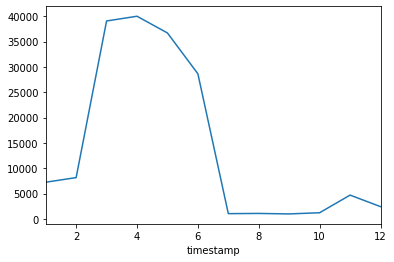

In [12]:
df[df.meter == 2].groupby(df[df.meter == 2].timestamp.dt.month)['meter_reading'].mean().plot()

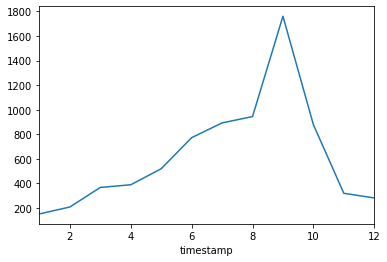

In [13]:
df[df.meter == 1].groupby(df[df.meter == 1].timestamp.dt.month)['meter_reading'].mean().plot()

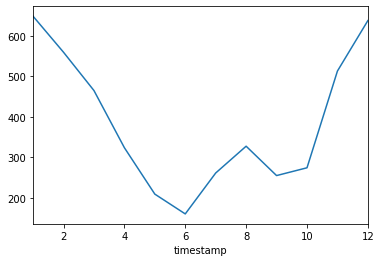

In [14]:
df[df.meter == 3].groupby(df[df.meter == 3].timestamp.dt.month)['meter_reading'].mean().plot()

In [16]:
df[df.meter == 3].building_id.unique()

array([ 106,  109,  112,  113,  114,  117,  119,  121,  138,  139,  144,
        145,  163,  166,  167,  168,  169,  171,  175,  176,  177,  179,
        183,  184,  187,  190,  191,  192,  195,  200,  201,  202,  203,
        206,  209,  210,  212,  213,  215,  216,  217,  220,  221,  224,
        225,  226,  228,  232,  234,  236,  239,  240,  244,  246,  247,
        248,  249,  250,  253,  254,  255,  260,  263,  264,  279,  284,
        287,  793,  794,  795,  998, 1000, 1003, 1008, 1009, 1011, 1012,
       1017, 1018, 1021, 1022, 1029, 1030, 1031, 1032, 1223, 1224, 1227,
       1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1240,
       1241, 1242, 1244, 1246, 1249, 1251, 1252, 1253, 1255, 1258, 1259,
       1260, 1262, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273,
       1274, 1275, 1276, 1293, 1294, 1295, 1296, 1297, 1298, 1300, 1301,
       1302, 1311, 1312, 1317, 1318, 1319, 1321, 1322, 1323, 1324, 1325,
       1331, 1028], dtype=int64)

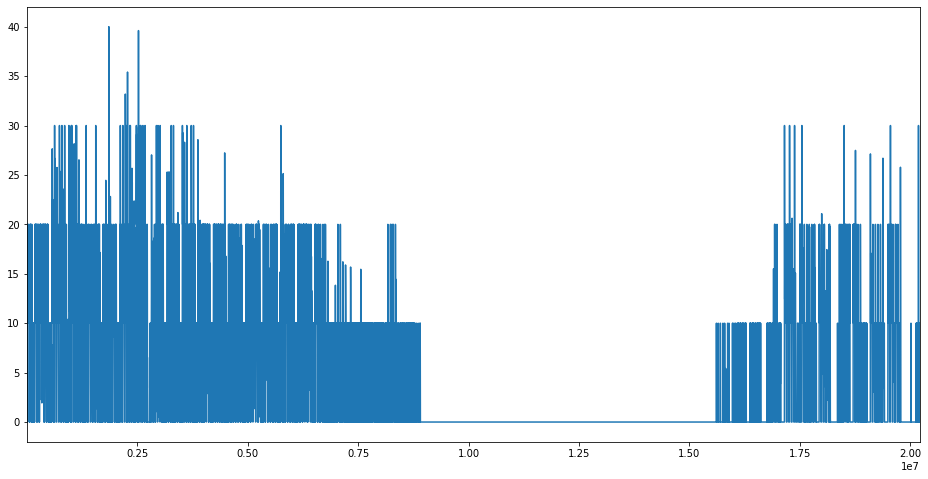

In [19]:
df[(df.building_id == 106) & (df.meter == 3)].meter_reading.plot(figsize=(16, 8))

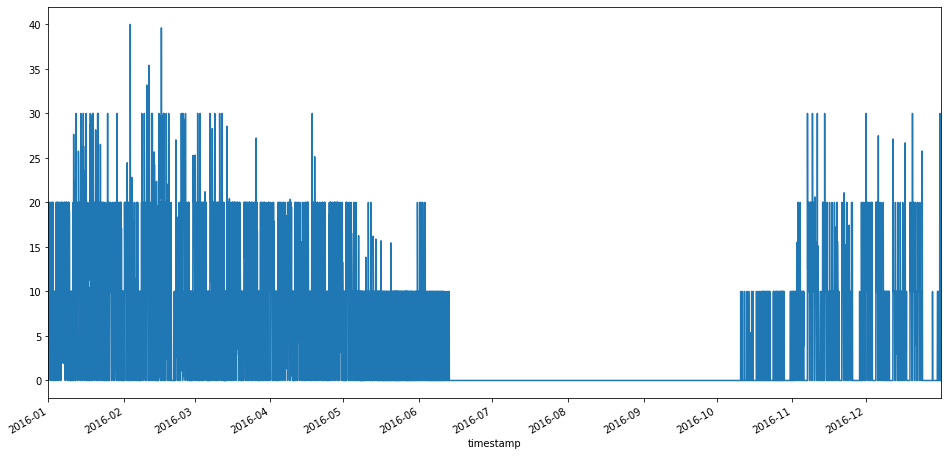

In [23]:
df[(df.building_id == 106) & (df.meter == 3)].set_index('timestamp').meter_reading.plot(figsize=(16, 8))

In [33]:
np.convolve([1,3,3,4,5,6], [0.25, 0.5, 0.25], mode='same')

array([1.25, 2.5 , 3.25, 4.  , 5.  , 4.25])

In [40]:
np.dot(np.array(0.25, 0.5, 0.25).reshape(1, -1), np.array([0, 1, 3]).reshape(-1,1))

ValueError: only 2 non-keyword arguments accepted

In [45]:
np.dot(np.array([1,3,3]), np.array([0.25, 0.5, 0.25]))

2.5

In [49]:
np.pad([1,2,3], (1,1), mode='edge')

array([1, 1, 2, 3, 3])

In [54]:
def smooth(x, weight):
    pad_width = int((len(weight) - 1) / 2)
    x_pad = np.pad(x, pad_width, mode='edge')
    return np.convolve(x_pad, weight, mode='valid')

In [55]:

x = [1,3,3,4,5,6]
box = [0.25, 0.5, 0.25]

In [56]:
smooth(x, box)

array([1.5 , 2.5 , 3.25, 4.  , 5.  , 5.75])

In [57]:
x = df[(df.building_id == 106) & (df.meter == 3)].set_index('timestamp').meter_reading.values

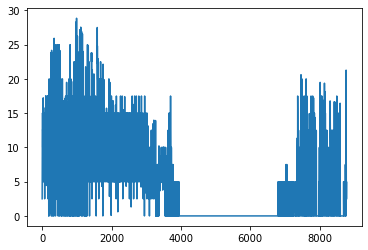

In [60]:
plt.plot(smooth(x, box))

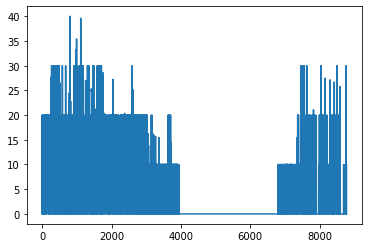

In [61]:
plt.plot(df[(df.building_id == 106) & (df.meter == 3)].set_index('timestamp').meter_reading.values)